In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import joblib

# Đọc file dữ liệu đã được xử lý và thêm feature
df = pd.read_csv('../data/processed_logs.csv')

print("Loaded processed data. Shape:", df.shape)
display(df.head())

feature_columns = [
    'request_count', 
    'unique_uri_count', 
    'http_404_count',
    'http_401_count'
]

X = df[feature_columns]

print("Selected features for training:")
print(feature_columns)

Loaded processed data. Shape: (268, 21)


,@timestamp,status,log,geoip,request_uri,useragent,body_bytes_sent,@version,tags,event,...,http_referer,http_user_agent,remote_addr,request_method,geoip.city_name,time_window,request_count,unique_uri_count,http_404_count,http_401_count
0,2025-10-17 14:24:08+00:00,404,{'file': {'path': '/var/log/nginx/access.log'}},{},/about-us,"{'device': {'name': 'Other'}, 'os': {'full': '...",153,1,['_geoip_lookup_failure'],"{'original': '{""@timestamp"":""2025-10-17T14:24:...",...,0.0,python-requests/2.31.0,172.18.0.1,GET,Unknown,2025-10-17 14:24:00+00:00,29,4,18,0
1,2025-10-17 14:24:10+00:00,200,{'file': {'path': '/var/log/nginx/access.log'}},{},/index.html,"{'device': {'name': 'Other'}, 'os': {'full': '...",615,1,['_geoip_lookup_failure'],"{'original': '{""@timestamp"":""2025-10-17T14:24:...",...,0.0,python-requests/2.31.0,172.18.0.1,GET,Unknown,2025-10-17 14:24:00+00:00,29,4,18,0
2,2025-10-17 14:24:13+00:00,404,{'file': {'path': '/var/log/nginx/access.log'}},{},/about-us,"{'device': {'name': 'Other'}, 'os': {'full': '...",153,1,['_geoip_lookup_failure'],"{'original': '{""@timestamp"":""2025-10-17T14:24:...",...,0.0,python-requests/2.31.0,172.18.0.1,GET,Unknown,2025-10-17 14:24:00+00:00,29,4,18,0
3,2025-10-17 14:24:16+00:00,404,{'file': {'path': '/var/log/nginx/access.log'}},{},/about-us,"{'device': {'name': 'Other'}, 'os': {'full': '...",153,1,['_geoip_lookup_failure'],"{'original': '{""@timestamp"":""2025-10-17T14:24:...",...,0.0,python-requests/2.31.0,172.18.0.1,GET,Unknown,2025-10-17 14:24:00+00:00,29,4,18,0
4,2025-10-17 14:24:16+00:00,200,{'file': {'path': '/var/log/nginx/access.log'}},{},/index.html,"{'device': {'name': 'Other'}, 'os': {'full': '...",615,1,['_geoip_lookup_failure'],"{'original': '{""@timestamp"":""2025-10-17T14:24:...",...,0.0,python-requests/2.31.0,172.18.0.1,GET,Unknown,2025-10-17 14:24:00+00:00,29,4,18,0


Selected features for training:
['request_count', 'unique_uri_count', 'http_404_count', 'http_401_count']


In [2]:
# Khởi tạo mô hình
# 'contamination' là tỷ lệ dự kiến của các điểm bất thường trong dữ liệu.
# 'auto' là giá trị tốt để bắt đầu, hoặc bạn có thể đặt một số nhỏ như 0.05 (5%)
model = IsolationForest(contamination='auto', random_state=42)

print("Training Isolation Forest model...")
# Huấn luyện mô hình trên dữ liệu feature
model.fit(X)
print("Model training completed.")

Training Isolation Forest model...
Model training completed.


In [3]:
# Dự đoán trên toàn bộ dữ liệu
# Kết quả trả về: 1 là bình thường (inlier), -1 là bất thường (outlier)
predictions = model.predict(X)

# Chuyển đổi -1 thành True (bất thường) và 1 thành False (bình thường) cho dễ đọc
df['is_anomaly'] = (predictions == -1)

print("Prediction completed. Anomaly counts:")
# Xem có bao nhiêu điểm bất thường được tìm thấy
print(df['is_anomaly'].value_counts())

Prediction completed. Anomaly counts:
is_anomaly
False    206
True      62
Name: count, dtype: int64


In [4]:
import os

# 1. Lưu DataFrame với cột dự đoán bất thường
final_output_path = '../data/final_logs_with_anomalies.csv'
df.to_csv(final_output_path, index=False)
print(f"Final data with anomaly predictions saved to '{final_output_path}'")

# 2. Lưu mô hình đã huấn luyện ra file để có thể tái sử dụng
model_path = '../models/isolation_forest_model.pkl'

# Lấy tên thư mục từ đường dẫn file
model_dir = os.path.dirname(model_path)
# Tạo thư mục nếu nó chưa tồn tại
os.makedirs(model_dir, exist_ok=True)
# -------------------

joblib.dump(model, model_path)
print(f"Trained model saved to '{model_path}'")

Final data with anomaly predictions saved to '../data/final_logs_with_anomalies.csv'
Trained model saved to '../models/isolation_forest_model.pkl'


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đặt style cho biểu đồ
sns.set_theme(style="whitegrid")

# Đọc file dữ liệu cuối cùng chứa kết quả dự đoán của AI
final_df = pd.read_csv('../data/final_logs_with_anomalies.csv')

print("Dữ liệu đã sẵn sàng để phân tích. Số dòng:", len(final_df))
print("Phân bổ các sự kiện bất thường:")
print(final_df['is_anomaly'].value_counts())

Dữ liệu đã sẵn sàng để phân tích. Số dòng: 268
Phân bổ các sự kiện bất thường:
is_anomaly
False    206
True      62
Name: count, dtype: int64


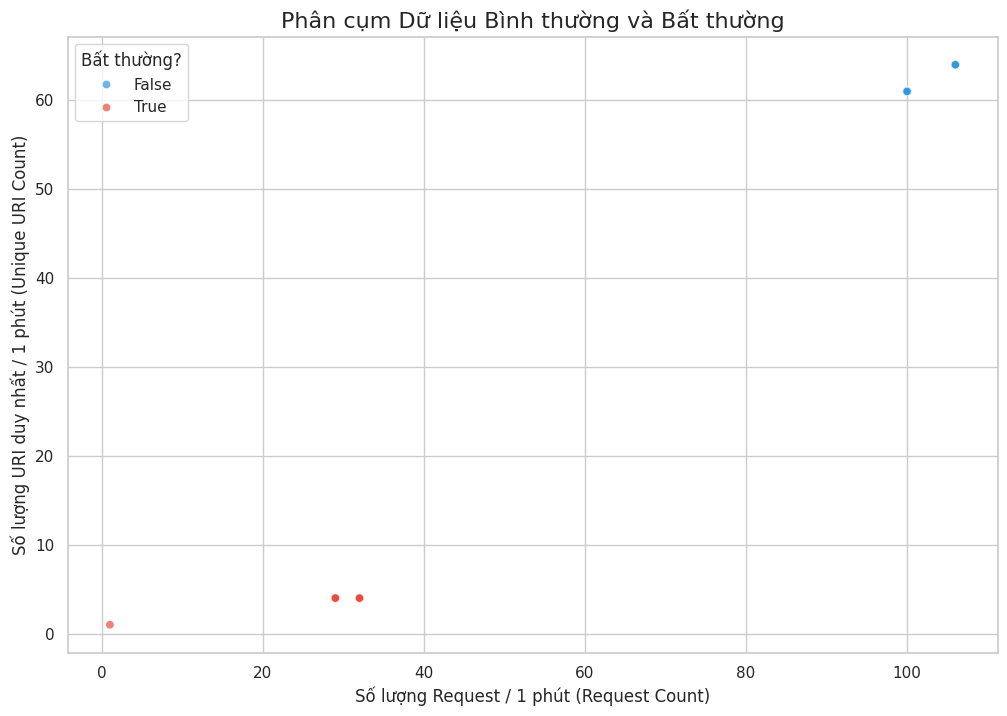

In [6]:
# Tạo một biểu đồ phân tán
plt.figure(figsize=(12, 8)) # Tăng kích thước biểu đồ cho dễ nhìn

# Vẽ biểu đồ với seaborn
# - Trục x: Số lượng request trong 1 phút
# - Trục y: Số lượng URI duy nhất đã truy cập trong 1 phút
# - Màu sắc (hue): Dựa trên kết quả của AI ('is_anomaly')
sns.scatterplot(
    data=final_df, 
    x='request_count', 
    y='unique_uri_count', 
    hue='is_anomaly',
    palette=['#3498db', '#e74c3c'], # Xanh cho bình thường, Đỏ cho bất thường
    alpha=0.7
)

# Đặt tiêu đề và nhãn cho các trục
plt.title('Phân cụm Dữ liệu Bình thường và Bất thường', fontsize=16)
plt.xlabel('Số lượng Request / 1 phút (Request Count)', fontsize=12)
plt.ylabel('Số lượng URI duy nhất / 1 phút (Unique URI Count)', fontsize=12)
plt.legend(title='Bất thường?')

# Hiển thị biểu đồ
plt.show()

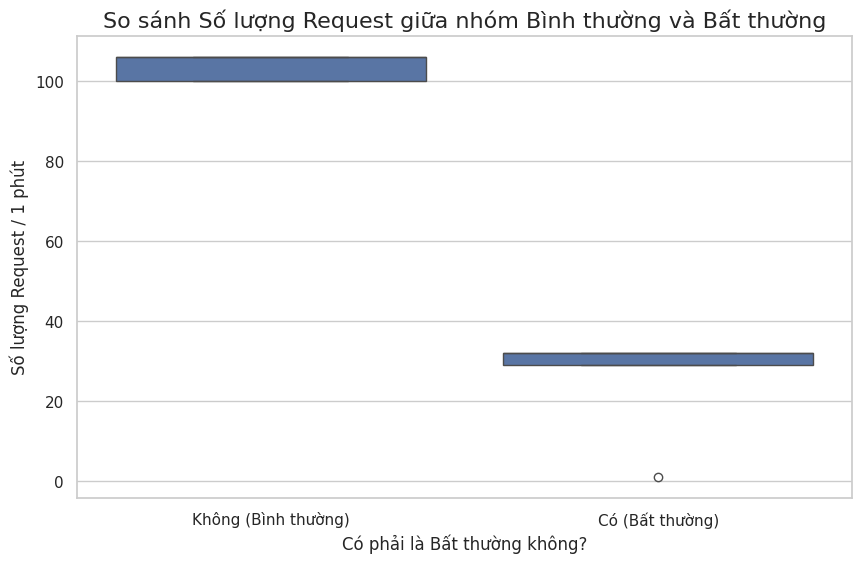

In [7]:
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ hộp so sánh sự phân bổ của 'request_count'
sns.boxplot(
    data=final_df,
    x='is_anomaly',
    y='request_count'
)

plt.title('So sánh Số lượng Request giữa nhóm Bình thường và Bất thường', fontsize=16)
plt.xlabel('Có phải là Bất thường không?', fontsize=12)
plt.ylabel('Số lượng Request / 1 phút', fontsize=12)
plt.xticks([0, 1], ['Không (Bình thường)', 'Có (Bất thường)']) # Đổi nhãn 0, 1 cho dễ hiểu

plt.show()